In [1]:
import warnings
warnings.filterwarnings('ignore')

import koreanize_matplotlib

In [2]:
import random
import numpy as np
import os

from xgboost import XGBRegressor

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [4]:
import pandas as pd

train_df = pd.read_csv('Data/train_c20729.csv')
train_df

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,요일_cos,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),월,일,월_sin,월_cos
0,"['1_20240601', '00']",1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.00,5794.80,...,-0.222521,82912.71,77586.0,0.0,0.0,0.0,0,1,0.0,1.0
1,"['1_20240601', '01']",1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.00,5591.85,...,-0.222521,82912.71,77586.0,0.0,0.0,0.0,0,1,0.0,1.0
2,"['1_20240601', '02']",1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.00,5338.17,...,-0.222521,82912.71,77586.0,0.0,0.0,0.0,0,1,0.0,1.0
3,"['1_20240601', '03']",1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.00,4554.42,...,-0.222521,82912.71,77586.0,0.0,0.0,0.0,0,1,0.0,1.0
4,"['1_20240601', '04']",1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.00,3602.25,...,-0.222521,82912.71,77586.0,0.0,0.0,0.0,0,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,"['100_20240824', '19']",100,2024-08-24 19:00:00,29.1,0.0,4.4,76.0,0.4,0.18,3276.00,...,-0.222521,162070.24,152943.0,0.0,0.0,0.0,0,24,0.0,1.0
203996,"['100_20240824', '20']",100,2024-08-24 20:00:00,28.6,0.0,3.7,74.0,0.0,0.00,3197.52,...,-0.222521,162070.24,152943.0,0.0,0.0,0.0,0,24,0.0,1.0
203997,"['100_20240824', '21']",100,2024-08-24 21:00:00,28.3,0.0,2.9,74.0,0.0,0.00,3006.60,...,-0.222521,162070.24,152943.0,0.0,0.0,0.0,0,24,0.0,1.0
203998,"['100_20240824', '22']",100,2024-08-24 22:00:00,28.0,0.0,1.7,76.0,0.0,0.00,2649.72,...,-0.222521,162070.24,152943.0,0.0,0.0,0.0,0,24,0.0,1.0


In [5]:
test_df = pd.read_csv('Data/test_c20729.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(°C)         16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  float64
 7   건물유형           16800 non-null  object 
 8   연면적(m2)        16800 non-null  float64
 9   냉방면적(m2)       16800 non-null  float64
 10  태양광용량(kW)      16800 non-null  float64
 11  ESS저장용량(kWh)   16800 non-null  float64
 12  PCS용량(kW)      16800 non-null  float64
 13  월              16800 non-null  int64  
 14  일              16800 non-null  int64  
 15  시간             16800 non-null  int64  
 16  요일             16800 non-null  int64  
 17  시간_sin         16800 non-null  float64
 18  시간_cos

In [6]:
train_df['건물유형'] = train_df['건물유형'].astype('category')

# train/ test set

In [7]:
train_x = train_df.drop(['num_date_time', '일시','일자', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],axis = 1)
train_y = train_df['전력소비량(kWh)']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((163200, 21), (40800, 21), (163200,), (40800,))

# 모델 학습

In [13]:
import xgboost
print(xgboost.__version__)


3.0.2


In [36]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300, 
    random_state=42,
    enable_categorical=True  
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:2715.94784	validation_1-rmse:2699.91598
[1]	validation_0-rmse:2046.98176	validation_1-rmse:2036.11389
[2]	validation_0-rmse:1613.85743	validation_1-rmse:1606.44794
[3]	validation_0-rmse:1339.21215	validation_1-rmse:1332.19928
[4]	validation_0-rmse:1126.78240	validation_1-rmse:1120.25333
[5]	validation_0-rmse:988.65340	validation_1-rmse:985.53497
[6]	validation_0-rmse:906.66327	validation_1-rmse:903.49287
[7]	validation_0-rmse:851.61535	validation_1-rmse:850.02813
[8]	validation_0-rmse:786.76696	validation_1-rmse:785.51955
[9]	validation_0-rmse:757.72598	validation_1-rmse:756.39390
[10]	validation_0-rmse:729.56943	validation_1-rmse:728.20242
[11]	validation_0-rmse:693.12874	validation_1-rmse:693.81190
[12]	validation_0-rmse:667.49921	validation_1-rmse:668.55730
[13]	validation_0-rmse:649.94133	validation_1-rmse:651.24568
[14]	validation_0-rmse:614.97441	validation_1-rmse:616.61079
[15]	validation_0-rmse:600.44783	validation_1-rmse:602.88923
[16]	validation_0-rmse:5

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [26]:
import numpy as np

def smape(y_true, y_pred):
    """
    SMAPE (Symmetric Mean Absolute Percentage Error)
    y_true: 실제값 (array-like)
    y_pred: 예측값 (array-like)
    반환값: SMAPE (단위: %)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_pred - y_true)
    # 0으로 나누는 경우는 diff=0 이므로 0으로 처리됨
    smape_val = 100 * np.mean(2 * diff / np.where(denominator == 0, 1, denominator))
    return smape_val


In [45]:
# 예측
val_pred = model.predict(X_val)
print(f'SMAPE: {smape(y_val, val_pred):.3f} %')


SMAPE: 10.980 %


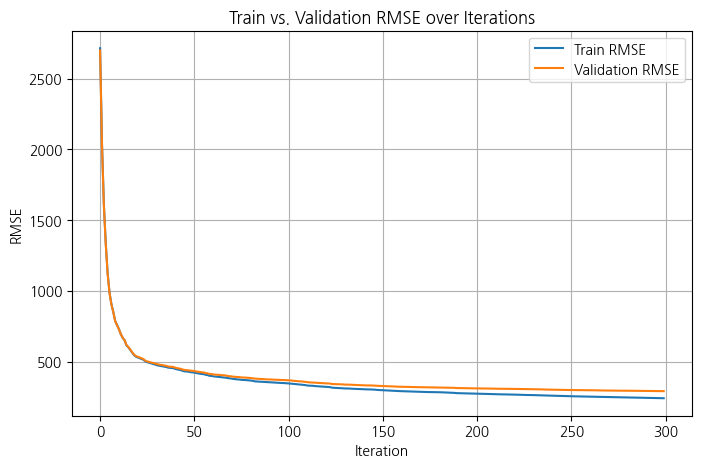

In [37]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse'] 

plt.figure(figsize=(8,5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Train vs. Validation RMSE over Iterations')
plt.legend()
plt.grid(True)
plt.show()


# 제출

In [38]:
test_df['건물유형'] = test_df['건물유형'].astype('category')

test_x = test_df.drop(['num_date_time','일시'],axis = 1)
test_x = test_x[X_train.columns]

pred =  model.predict(test_x)
pred

array([4580.9434, 4595.2236, 4536.1562, ..., 2386.2046, 2278.1887,
       2482.4458], shape=(16800,), dtype=float32)

In [40]:
submit = pd.read_csv('Data/sample_submission.csv')
submit['answer'] = pred

In [44]:
#smpe: 10.980% /submit:15.14796
submit.to_csv('Submit/submit0729.csv',index = False)